# Exploring UniRep representations of TEM-1 beta lactamase data

First we import the JAX Unirep package as well as mount the google drive folder.

In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-2h1vcjoa
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-2h1vcjoa
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=135455665 sha256=f700fcbf322c1cec90f5da53cd58e2be410cc5be240bfdc795d504397343aca0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9rjboybp/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
     |████████████████████████████████| 163kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 112kB 16.1MB/s 
     |████████████████████████████████| 61kB 6.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
blac_fitness.txt		       out_domain_val_set.fasta.txt
blac_seqs.txt			       out_domain_val_set_formatted.fasta.txt
blac_unirep_global_init_1	       seqs.txt
blac_unirep_global_init_1.zip	       temp
blac_unirep_random_init_1.zip	       train_set.fasta.txt
data_exploration_jax.ipynb	       train_set_formatted.fasta.txt
data_utils.py			       train_top.ipynb
formatted.txt			       unirep.py
get_reps.ipynb			       unirep_tutorial.ipynb
in_domain_val_set.fasta.

In [3]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Load sequences

In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

In [0]:
# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt', dtype='float')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

In [0]:
# Load PETase training data (unlabeled)
#train_df = pd.DataFrame(read_fasta('train_set'), columns = ['name', 'sequence'])
#out_val_df = pd.DataFrame(read_fasta('out_domain_val_set'), columns = ['name', 'sequence'])


In [6]:
# load labeled TEM-1 beta lactamase data
blac_df = pd.DataFrame(read_labeled_data('blac'), columns = ['sequence', 'fitness'])
N_seqs = len(blac_df)
print(N_seqs)
blac_df.head()

5469


,sequence,fitness
0,ASIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002018
1,CSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.003023
2,DSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002220
3,ESIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002378
4,FSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.005702


## Get Reps


In [0]:
# load params for TEM-1 blac weights
blac_params = load_params_1900(gdrive_path + 'blac_unirep_global_init_1')

In [8]:
# vary batches based on memory available
N_BATCHES = 6

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

# get 1st sequence representation
unirep, _, _ = get_reps(blac_df.sequence[0])

feat_cols = [ 'feat' + str(j) for j in range(1, unirep.shape[1] + 1) ]
unirep_df = pd.DataFrame(unirep, columns=feat_cols)
unirep_df.insert(0, "sequence", blac_df.sequence)
unirep_df.insert(1, "fitness", blac_df.fitness)

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps(blac_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] )
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", blac_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_unirep_df.insert(1, "fitness", blac_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  unirep_df = pd.concat([unirep_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

unirep_df.head()

,sequence,fitness,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,...,feat1861,feat1862,feat1863,feat1864,feat1865,feat1866,feat1867,feat1868,feat1869,feat1870,feat1871,feat1872,feat1873,feat1874,feat1875,feat1876,feat1877,feat1878,feat1879,feat1880,feat1881,feat1882,feat1883,feat1884,feat1885,feat1886,feat1887,feat1888,feat1889,feat1890,feat1891,feat1892,feat1893,feat1894,feat1895,feat1896,feat1897,feat1898,feat1899,feat1900
0,ASIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002018,0.006393,0.061514,0.082276,-0.069812,-0.008325,0.043463,-0.029138,-0.027969,-0.003247,0.006486,0.011812,-0.000430,0.109089,-0.000852,0.010409,0.000596,0.032210,-0.096915,0.306315,-0.020235,-0.027572,0.003067,0.127749,-0.044427,0.019713,-0.126782,-0.104340,0.016117,-0.142348,-0.035614,-0.306750,-0.120456,0.024573,0.130998,-0.070193,-0.025041,0.021142,0.041073,...,-0.069182,0.039075,-0.061717,0.235480,-0.125720,-0.200845,0.001370,-0.427949,-0.006289,-0.202775,0.265091,0.083800,0.054710,-0.142238,-0.154167,0.090707,-0.044974,0.018514,0.132693,0.331736,0.070827,0.064426,0.083994,-0.006803,0.006911,0.036685,-0.195305,0.169444,-0.003092,0.001965,0.213317,0.026809,-0.115964,0.046200,-0.109487,0.045421,0.145133,-0.085517,-0.133907,-0.024836
1,CSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.003023,0.006385,0.064631,0.074807,-0.067615,-0.028016,0.043017,-0.040085,-0.024445,-0.003488,0.014626,0.004320,-0.000718,0.112896,-0.001175,0.010434,0.000832,0.032196,-0.095935,0.302016,-0.019599,-0.027111,0.004974,0.123204,-0.053098,0.018248,-0.143133,-0.113555,0.016043,-0.138350,-0.036155,-0.302836,-0.115741,0.024028,0.119746,-0.066814,-0.023622,0.020676,0.044126,...,-0.065319,0.037860,-0.062924,0.235210,-0.123468,-0.200165,0.001371,-0.442076,-0.006250,-0.207354,0.266556,0.083947,0.057630,-0.149645,-0.155603,0.098375,-0.040914,0.016993,0.136424,0.340634,0.068295,0.071418,0.082356,-0.006224,0.006429,0.035995,-0.205940,0.163352,-0.004220,0.009154,0.211730,0.027225,-0.114463,0.046574,-0.107344,0.052469,0.135533,-0.068176,-0.126432,-0.023300
2,DSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002220,0.006561,0.071035,0.076654,-0.064301,-0.065528,0.056060,-0.023186,-0.024507,-0.003463,0.010985,0.022532,-0.000250,0.130085,-0.016969,0.010596,0.000488,0.029317,-0.096254,0.299144,-0.020229,-0.027370,-0.003838,0.123579,-0.046497,0.022459,-0.157626,-0.098857,0.016283,-0.132828,-0.034613,-0.300996,-0.118324,0.023194,0.117117,-0.066947,-0.025845,0.020130,0.037580,...,-0.078227,0.036780,-0.061364,0.246887,-0.124881,-0.199713,0.001363,-0.459598,-0.007082,-0.225476,0.241602,0.080416,0.049696,-0.158728,-0.177498,0.101100,-0.030911,0.018873,0.114263,0.355006,0.072606,0.047815,0.067286,-0.006510,0.008106,0.046360,-0.194177,0.164565,-0.005008,0.002902,0.240089,0.015659,-0.132623,0.047834,-0.103569,0.038674,0.132507,-0.072743,-0.127861,-0.022262
3,ESIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002378,0.006579,0.069527,0.076349,-0.064894,-0.052338,0.051859,-0.025333,-0.027768,-0.003354,0.011074,0.015648,-0.000301,0.126658,-0.013644,0.010268,0.000661,0.030407,-0.094195,0.301291,-0.021215,-0.027132,-0.005063,0.125097,-0.052000,0.020924,-0.148345,-0.103454,0.016297,-0.135253,-0.033349,-0.303102,-0.120630,0.024016,0.115920,-0.065122,-0.025201,0.019953,0.043651,...,-0.074485,0.036861,-0.058950,0.247896,-0.127939,-0.201003,0.001365,-0.450694,-0.006979,-0.218744,0.241533,0.081369,0.051048,-0.155976,-0.161499,0.096673,-0.034137,0.018742,0.122309,0.352959,0.070076,0.056334,0.069187,-0.006784,0.007786,0.046890,-0.199220,0.169092,-0.004864,0.004656,0.237356,0.019714,-0.129176,0.045762,-0.102923,0.038223,0.136313,-0.082839,-0.131641,-0.021245
4,FSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.005702,0.006560,0.068790,0.074779,-0.064711,-0.064217,0.049007,-0.037670,-0.028824,-0.003

In [9]:
# do the same for eunirep

# get 1st sequence representation
eunirep, _, _ = get_reps(blac_df.sequence[0], params=blac_params)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep.shape[1] + 1) ]
eunirep_df = pd.DataFrame(eunirep, columns=efeat_cols)
eunirep_df.insert(0, "sequence", blac_df.sequence)
eunirep_df.insert(1, "fitness", blac_df.fitness)

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(blac_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=blac_params)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", blac_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", blac_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep_df = pd.concat([eunirep_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep_df.head()

,sequence,fitness,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,...,feat1861,feat1862,feat1863,feat1864,feat1865,feat1866,feat1867,feat1868,feat1869,feat1870,feat1871,feat1872,feat1873,feat1874,feat1875,feat1876,feat1877,feat1878,feat1879,feat1880,feat1881,feat1882,feat1883,feat1884,feat1885,feat1886,feat1887,feat1888,feat1889,feat1890,feat1891,feat1892,feat1893,feat1894,feat1895,feat1896,feat1897,feat1898,feat1899,feat1900
0,ASIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002018,0.112683,0.031447,-0.040608,-0.230704,-0.253998,0.129052,-0.133854,-0.021728,-0.219280,0.025734,0.036117,-0.093045,0.248653,-0.173888,0.026002,0.078071,0.101783,-0.116817,0.323628,-0.200481,-0.306993,-0.066049,0.159515,-0.001172,-0.040972,-0.251234,-0.139890,0.048752,-0.191246,0.111659,-0.225381,-0.245005,0.102588,-0.102670,-0.082439,-0.045031,0.086308,0.122389,...,-0.097033,0.118055,-0.144448,0.364698,-0.228451,-0.158741,0.001485,-0.027469,-0.103940,-0.449232,0.426256,0.092808,0.153421,-0.150194,-0.245184,0.041064,-0.080276,0.007813,-0.000920,0.408676,0.027927,-0.258478,0.065808,-0.289852,0.144617,0.113901,-0.434952,0.060715,-0.035121,0.054871,0.472586,0.037651,-0.022472,0.016676,-0.170224,0.081393,0.066594,-0.130250,-0.259630,-0.028305
1,CSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.003023,0.105991,0.030950,-0.028185,-0.219377,-0.271234,0.143442,-0.160274,-0.018634,-0.200994,0.033427,0.019905,-0.109909,0.228143,-0.195854,0.023360,0.084770,0.099305,-0.101747,0.343532,-0.201180,-0.275762,-0.058283,0.148792,-0.034769,-0.040840,-0.279740,-0.124739,0.045762,-0.190820,0.099931,-0.226315,-0.248045,0.109133,-0.058968,-0.085055,-0.057663,0.089644,0.108335,...,-0.108680,0.104862,-0.131493,0.364711,-0.245098,-0.132475,0.001558,-0.116015,-0.091318,-0.417038,0.429656,0.096952,0.137262,-0.144181,-0.231522,0.050706,-0.088821,0.013439,0.025344,0.425649,0.012439,-0.233815,0.066152,-0.251512,0.109579,0.089337,-0.421124,0.074122,-0.041165,0.051976,0.418139,0.045974,-0.057873,0.037586,-0.177401,0.073746,0.076289,-0.103949,-0.280883,-0.020340
2,DSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002220,0.101689,0.032626,-0.019149,-0.222166,-0.266124,0.139457,-0.145140,-0.018224,-0.199949,0.033369,0.027436,-0.111224,0.232169,-0.179310,0.021121,0.081928,0.097821,-0.104494,0.357039,-0.197500,-0.280039,-0.062072,0.150753,-0.040354,-0.046722,-0.276548,-0.145272,0.045814,-0.188429,0.102826,-0.229310,-0.252784,0.103393,-0.058783,-0.084024,-0.053239,0.091220,0.108885,...,-0.114008,0.102937,-0.131570,0.366565,-0.247258,-0.135007,0.001557,-0.114900,-0.090221,-0.413905,0.426513,0.085910,0.130899,-0.145521,-0.243132,0.057269,-0.089163,0.013180,0.023588,0.432316,0.009892,-0.243250,0.063358,-0.246747,0.110631,0.087691,-0.416476,0.071223,-0.031136,0.050248,0.421136,0.050502,-0.064478,0.035053,-0.178228,0.069164,0.079517,-0.115922,-0.280553,-0.019644
3,ESIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.002378,0.098716,0.032648,-0.022886,-0.219397,-0.263348,0.141850,-0.146926,-0.019018,-0.199208,0.034655,0.030265,-0.112538,0.231116,-0.183474,0.023736,0.080387,0.098960,-0.103158,0.356036,-0.202664,-0.279450,-0.059848,0.153098,-0.044628,-0.039509,-0.275542,-0.147061,0.047352,-0.184461,0.099048,-0.226883,-0.251685,0.101615,-0.054328,-0.084085,-0.055405,0.089940,0.109604,...,-0.112125,0.105777,-0.136335,0.360109,-0.245747,-0.148038,0.001554,-0.116163,-0.091474,-0.416235,0.427814,0.090142,0.132389,-0.142798,-0.238409,0.055041,-0.087495,0.011317,0.032104,0.426544,0.010536,-0.239638,0.062860,-0.248408,0.103907,0.092321,-0.428043,0.076897,-0.030144,0.050783,0.417868,0.046443,-0.063653,0.034299,-0.174428,0.066323,0.083204,-0.112429,-0.280814,-0.019635
4,FSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0.005702,0.098641,0.027090,-0.040766,-0.224691,-0.280022,0.146099,-0.141551,

## Data Exploration

In [10]:
# 3 component PCA on unirep representations:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(unirep_df[feat_cols].values)
unirep_df['pca1'] = pca_result[:,0]
unirep_df['pca2'] = pca_result[:,1] 
unirep_df['pca3'] = pca_result[:,2]
print('UniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep_df[efeat_cols].values)
eunirep_df['pca1'] = pca_result[:,0]
eunirep_df['pca2'] = pca_result[:,1] 
eunirep_df['pca3'] = pca_result[:,2]
print('eUniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

UniRep: Explained variation per principal component: [0.61166084 0.22256088 0.03027717]
eUniRep: Explained variation per principal component: [0.79283816 0.01767815 0.01440086]


<Figure size 432x288 with 0 Axes>

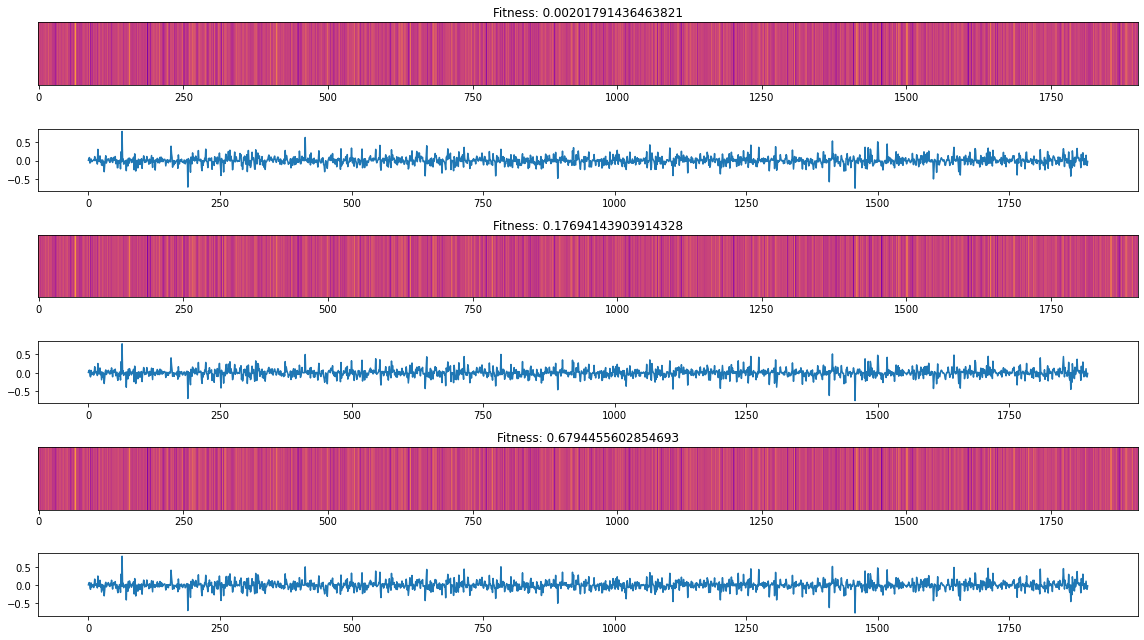

In [11]:
# visualize full representation of each sequence by feature value
# we don't expect to get anything out of these plots
INDCES_TO_SHOW = [0,22,180]

plt.clf()
fig = plt.figure(figsize=(16,3*len(INDCES_TO_SHOW)))
x = np.arange(len(feat_cols))
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]

for i in range(len(INDCES_TO_SHOW)):
  y = unirep_df.loc[INDCES_TO_SHOW[i], feat_cols].values.astype(float)

  ax = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,(i*2+1), title="Fitness: " + str(unirep_df.loc[INDCES_TO_SHOW[i],'fitness']))
  ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
  ax.set_yticks([])
  ax.set_xlim(extent[0], extent[1])

  ax2 = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,i*2+2)
  ax2.plot(x,y)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

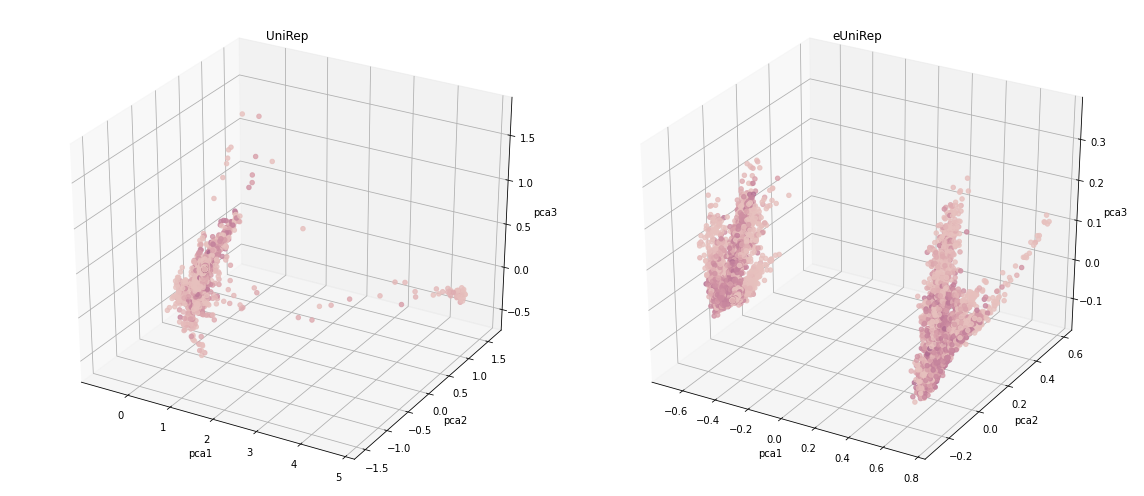

In [12]:
# 3D Plot of first 3 PC's

plt.clf()
fig = plt.figure( figsize=(16,7) )

ax = fig.add_subplot(1,2,1, title="UniRep", projection="3d")
ax.scatter(
    xs=unirep_df["pca1"], 
    ys=unirep_df["pca2"], 
    zs=unirep_df["pca3"], 
    c=unirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')

ax2 = fig.add_subplot(1,2,2, title="eUniRep", projection="3d")
ax2.scatter(
    xs=eunirep_df["pca1"], 
    ys=eunirep_df["pca2"], 
    zs=eunirep_df["pca3"], 
    c=eunirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax2.set_xlabel('pca1')
ax2.set_ylabel('pca2')
ax2.set_zlabel('pca3')

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

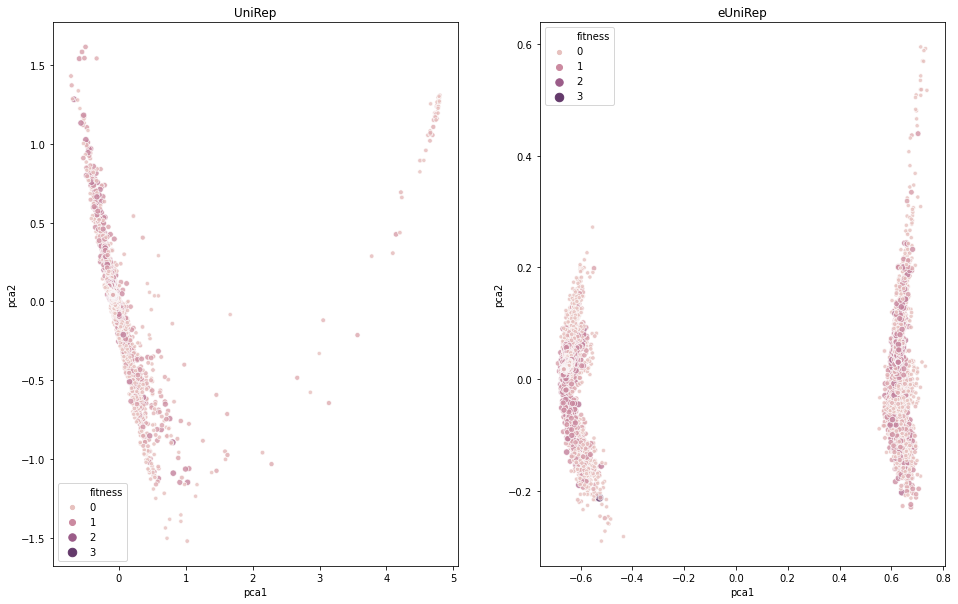

In [13]:
# plot PCA1 vs PCA2 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca1", y="pca2",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca1", y="pca2",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



<Figure size 432x288 with 0 Axes>

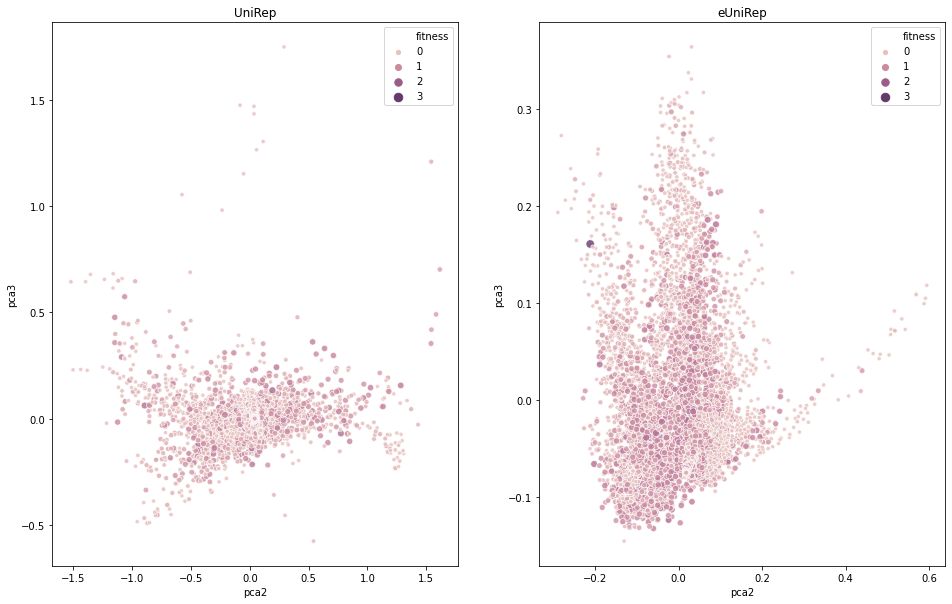

In [14]:
# plot PCA2 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca2", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca2", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



<Figure size 432x288 with 0 Axes>

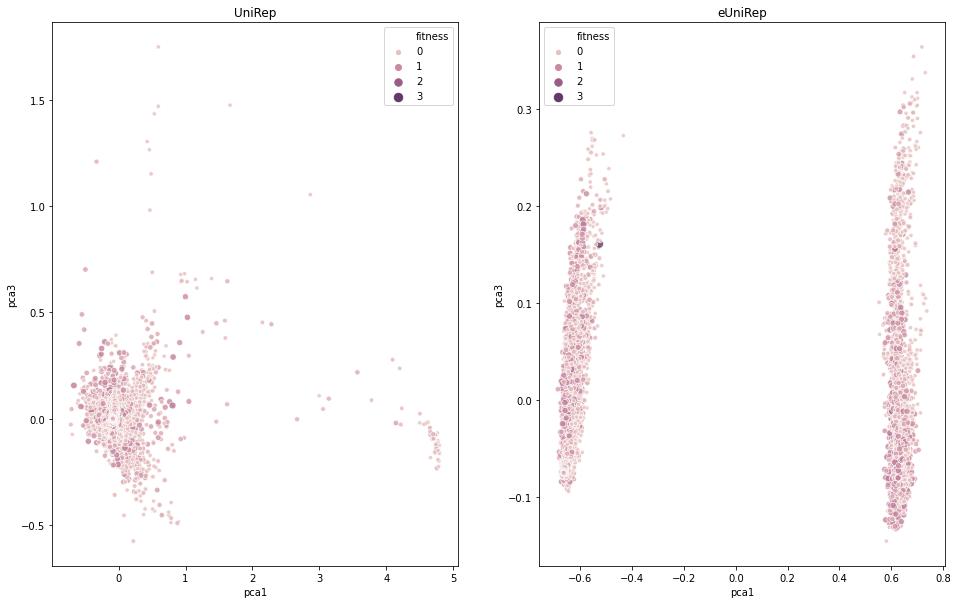

In [15]:
# plot PCA1 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca1", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca1", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



In [16]:
# How many PCA's do we need to keep to get >90% variance kept?

# UNIREP:
pca_N = PCA(n_components=24)
pca_result_N = pca_N.fit_transform(unirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(pca_N.explained_variance_ratio_)))

# eUNIREP:
epca_N = PCA(n_components=24)
epca_result_N = epca_N.fit_transform(eunirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(epca_N.explained_variance_ratio_)))


UniRep: Explained variation per principal component: 0.9675857424736023
UniRep: Explained variation per principal component: 0.9015745520591736


In [17]:
# run TSNE with 2 components on the 24-component PCAs

# UNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_N)

# add tsne results to dataframe
unirep_df['tsne-2d-1'] = tsne_results[:,0]
unirep_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca_result_N)

# add tsne results to dataframe
eunirep_df['tsne-2d-1'] = tsne_results[:,0]
eunirep_df['tsne-2d-2'] = tsne_results[:,1]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.019s...
[t-SNE] Computed neighbors for 5469 samples in 0.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional probabilities for sample 3000 / 5469
[t-SNE] Computed conditional probabilities for sample 4000 / 5469
[t-SNE] Computed conditional probabilities for sample 5000 / 5469
[t-SNE] Computed conditional probabilities for sample 5469 / 5469
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.373657
[t-SNE] KL divergence after 300 iterations: 1.984660
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5469 samples in 0.020s...
[t-SNE] Computed neighbors for 5469 samples in 0.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5469
[t-SNE] Computed conditional probabilities for sample 2000 / 5469
[t-SNE] Computed conditional

<Figure size 432x288 with 0 Axes>

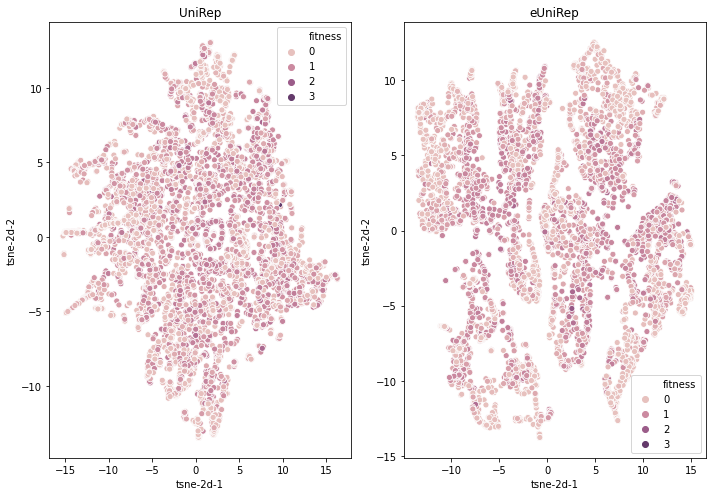

In [18]:
# plot t-SNE's:
plt.clf()
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(1,2,1, title="UniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    #alpha=0.3
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    #alpha=0.3
)


plt.tight_layout()
plt.show()

## Top Model Training & Performance Testing

In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

In [20]:
# turn ePCA_24 into a dataframe for use as X for top model training
pca_eX_df = pd.DataFrame(epca_result_N, columns = [ 'pca' + str(j) for j in range(1, epca_result_N.shape[1] + 1) ])
pca_eX_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.604480,-0.021599,-0.062110,-0.020198,0.060302,-0.036468,0.105541,-0.002002,0.042108,-0.023938,-0.005137,-0.026143,-0.010799,0.004126,-0.016456,-0.005659,-0.093016,0.083742,0.031842,-0.018259,0.029173,0.043830,-0.002913,0.005252
1,0.657811,-0.093371,0.019534,-0.032917,0.069188,-0.013605,0.121121,-0.003416,0.021789,-0.011788,0.077460,-0.045951,-0.050171,-0.027828,0.002264,-0.026876,-0.080569,0.087156,-0.030140,0.004687,-0.004853,0.001305,0.019383,-0.012208
2,0.672803,-0.102489,0.020717,-0.024949,0.097514,-0.034694,0.200883,-0.008679,0.077676,0.001708,0.083059,-0.061302,-0.072083,-0.051601,0.006760,-0.001595,-0.129142,0.091465,-0.028239,0.002211,-0.010798,0.005623,0.026341,0.004955
3,0.678304,-0.095064,-0.008850,-0.019264,0.106758,-0.037242,0.161353,0.001623,0.050572,-0.011801,0.087530,-0.045160,-0.071484,-0.038990,-0.007601,-0.007368,-0.103561,0.104224,-0.017150,0.024640,-0.017414,0.007021,0.019982,0.012388
4,0.649069,-0.083547,-0.099199,-0.040719,0.068926,-0.075745,0.092474,0.005484,0.028121,-0.040438,-0.001073,-0.056986,-0.039086,-0.035074,0.056254,-0.001774,-0.060656,0.084399,0.018211,0.000091,-0.016152,0.029604,0.004523,0.039779


UniRep alpha chosen: 11.288378916846883
eUniRep alpha chosen: 0.08858667904100823
PCA_eUniRep alpha chosen: 0.08858667904100823


<Figure size 432x288 with 0 Axes>

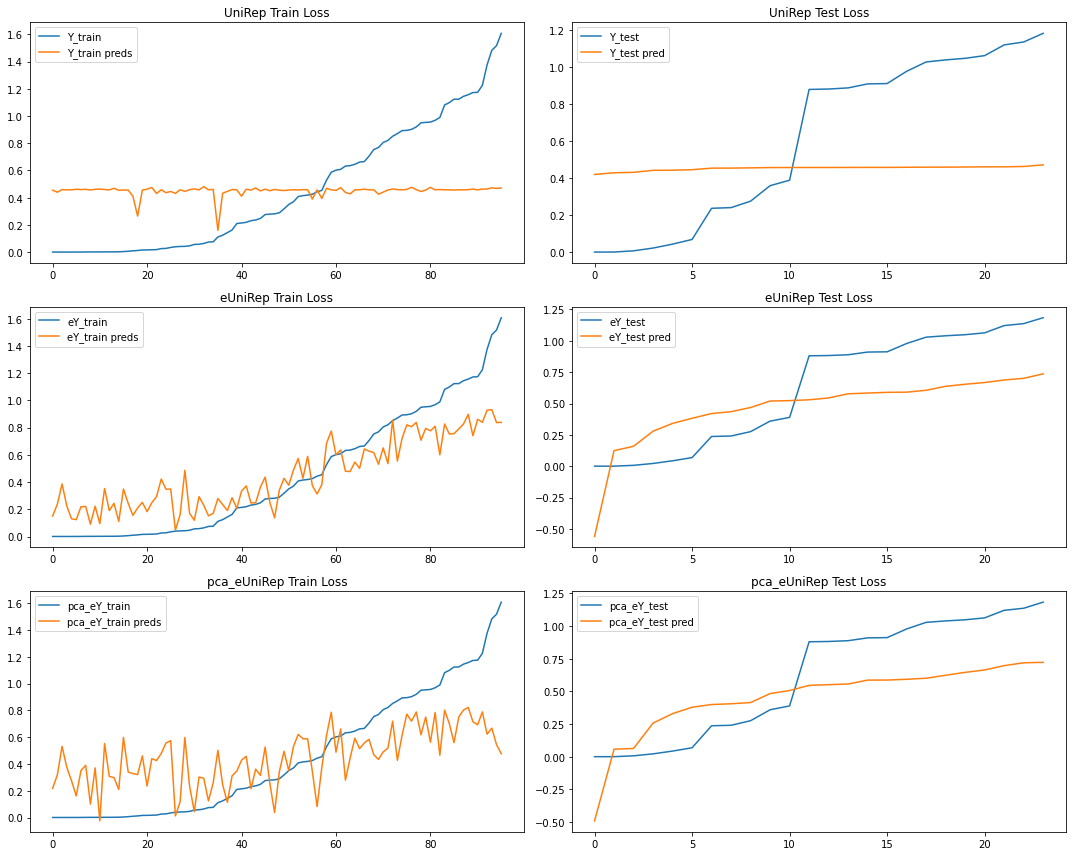

In [23]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(eunirep_df.shape[0])

# number of sequences per batch (chosen such that N_train=96)
BATCH_SIZE = 120

X = unirep_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
eX = eunirep_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
pca_eX = pca_eX_df.loc[rndperm[0:BATCH_SIZE]]
Y = eunirep_df.loc[rndperm[0:BATCH_SIZE], "fitness"]

# train-test split for both 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eX_train, eX_test, eY_train, eY_test = train_test_split(eX, Y, test_size=0.2, random_state=42)
pca_eX_train, pca_eX_test, pca_eY_train, pca_eY_test = train_test_split(pca_eX, Y, test_size=0.2, random_state=42)


# ridge regression model setup
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

model = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
pca_emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)

# UNCOMMENT THIS TO SEE ALL THE ALPHAS TESTED
#ridge_params = model.get_params()
#print('alphas to test:', ridge_params['alphas'])

# fit the model
model.fit(X_train, Y_train)
print('UniRep alpha chosen:', str(model.alpha_))
emodel.fit(eX_train, eY_train)
print('eUniRep alpha chosen:', str(emodel.alpha_))
pca_emodel.fit(pca_eX_train, pca_eY_train)
print('PCA_eUniRep alpha chosen:', str(pca_emodel.alpha_))


# predict fitness to get train and test losses
Y_train_preds = model.predict(X_train)
Y_test_preds = model.predict(X_test)
eY_train_preds = emodel.predict(eX_train)
eY_test_preds = emodel.predict(eX_test)
pca_eY_train_preds = pca_emodel.predict(pca_eX_train)
pca_eY_test_preds = pca_emodel.predict(pca_eX_test)

train_loss = np.linalg.norm(Y_train_preds - Y_train)
test_loss = np.linalg.norm(Y_test_preds - Y_test)
etrain_loss = np.linalg.norm(eY_train_preds - eY_train)
etest_loss = np.linalg.norm(eY_test_preds - eY_test)
pca_etrain_loss = np.linalg.norm(pca_eY_train_preds - pca_eY_train)
pca_etest_loss = np.linalg.norm(pca_eY_test_preds - pca_eY_test)

# plot train and test losses
plt.clf()
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(3,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(3,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test_preds)])
ax2.legend(['Y_test','Y_test pred'])

ax3 = fig.add_subplot(3,2,3, title="eUniRep Train Loss")
ax3.plot(np.arange(len(eY_train)), np.array(eY_train)[np.argsort(eY_train)])
ax3.plot(np.arange(len(eY_train)), np.array(eY_train_preds)[np.argsort(eY_train)])
ax3.legend(['eY_train','eY_train preds'])

ax4 = fig.add_subplot(3,2,4, title="eUniRep Test Loss")
ax4.plot(np.arange(len(eY_test)), np.array(eY_test)[np.argsort(eY_test)])
ax4.plot(np.arange(len(eY_test)), np.array(eY_test_preds)[np.argsort(eY_test_preds)])
ax4.legend(['eY_test','eY_test pred'])

ax5 = fig.add_subplot(3,2,5, title="pca_eUniRep Train Loss")
ax5.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train)[np.argsort(pca_eY_train)])
ax5.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train_preds)[np.argsort(pca_eY_train)])
ax5.legend(['pca_eY_train','pca_eY_train preds'])

ax6 = fig.add_subplot(3,2,6, title="pca_eUniRep Test Loss")
ax6.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test)[np.argsort(pca_eY_test)])
ax6.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test_preds)[np.argsort(pca_eY_test_preds)])
ax6.legend(['pca_eY_test','pca_eY_test pred'])

plt.tight_layout()
plt.show()


## Improvement over random sampling 
Test top model function in the same way as done in Supplementary Figure 2 of the Low-N engineering paper (but for TEM-1 instead of avGFP; and instead of training on Sarkisyan and testing on SynNeigh and FP Homologs, this trains and tests on random splits of Firnberg et al)

The purpose of doing this despite the clearly good fit function for Ridge Regression (see above) is for use as a comparision for datasets that may look less ideal (i.e. <96 training data points)

In [37]:
# number of batches to test
N_BATCH = 5

# number of sequences per training batch
TRAIN_BATCH_SIZE = 96

# number of sequences per training batch
HOLDOUT_BATCH_SIZE = 960

# number of random trials to perform for baseline
N_RAND_BATCHES = 10

unirep_scores = []
eunirep_scores = []
pca_eunirep_scores = []
for i in range(N_BATCH):
  # change random seed for each batch
  np.random.seed(42*(i+2))
  rndperm = np.random.permutation(eunirep_df.shape[0])

  # data setup
  X = unirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  eX = eunirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  pca_eX = pca_eX_df.loc[rndperm[0:TRAIN_BATCH_SIZE]]
  Y = eunirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

  X_holdout = unirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  eX_holdout = eunirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  pca_eX_holdout = pca_eX_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE]]
  Y_holdout = eunirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

  # ridge regression model setup
  kfold = KFold(n_splits=10, shuffle=True)

  model = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  pca_emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)

  # fit the model
  model.fit(X, Y)
  emodel.fit(eX, Y)
  pca_emodel.fit(pca_eX, Y)

  # use model to sort holdout set and get top 96 predicted fitness
  Y_preds = model.predict(X_holdout)
  eY_preds = emodel.predict(eX_holdout)
  pca_eY_preds = pca_emodel.predict(pca_eX_holdout)

  usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:96]
  esorted = np.array(Y_holdout)[np.argsort(eY_preds)][::-1][:96]
  pca_esorted = np.array(Y_holdout)[np.argsort(pca_eY_preds)][::-1][:96]

  # Note: wild-type fitness = 1 (thats the scoring metric)
  usorted_count = np.sum([1 if i > 1 else 0 for i in usorted])
  esorted_count = np.sum([1 if i > 1 else 0 for i in esorted])
  pca_esorted_count = np.sum([1 if i > 1 else 0 for i in pca_esorted])

  # randomly shuffle holdout set RAND_BATCHES time
  # and take average of top 96 fitness
  avg_rand_count = 0
  for j in range(N_RAND_BATCHES):
    np.random.seed(42*(i+2) + (1+j))
    rand_Y = np.random.permutation(np.array(Y_holdout))[0:96]
    avg_rand_count += np.sum([1 if i > 1 else 0 for i in rand_Y])
  avg_rand_count /= N_RAND_BATCHES

  # final score ratio:
  unirep_scores.append(usorted_count/avg_rand_count)
  eunirep_scores.append(esorted_count/avg_rand_count)
  pca_eunirep_scores.append(pca_esorted_count/avg_rand_count)

# note: random baseline = 1 (as these are ratios)
print("UniRep:", unirep_scores, "Mean Score:", np.mean(unirep_scores))
print("eUniRep:", eunirep_scores, "Mean Score:", np.mean(eunirep_scores))
print("PCA_eUniRep:", pca_eunirep_scores, "Mean Score:", np.mean(pca_eunirep_scores))

UniRep: [1.0599078341013826, 0.9375000000000001, 0.8465608465608466, 1.244019138755981, 0.7251908396946565] Mean Score: 0.9626357318225732
eUniRep: [1.9815668202764978, 1.8750000000000002, 2.0105820105820107, 2.105263157894737, 1.83206106870229] Mean Score: 1.9608946114911074
PCA_eUniRep: [1.8894009216589862, 1.8750000000000002, 2.2751322751322753, 1.9617224880382778, 1.7938931297709924] Mean Score: 1.9590297629201063
